In [1]:
%run '0.0_init_configuration.ipynb'

In [2]:
# Importamos activo de yfince
activo = 'BTC-USD'
df = yf.Ticker(activo)
df = df.history(start='2018-01-01', end='2025-04-07')

**Utilizaremos las EMA 22 y 68 testeada previamente**

In [3]:
#Cálculo de EMA
df['EMA_22'] = ta.EMA(df['Close'], timeperiod=22)
df['EMA_68'] = ta.EMA(df['Close'], timeperiod=68)

In [4]:
# Método de tendencias 
df['Signal'] = 0

df.loc[df['EMA_22'] > df['EMA_68'], 'Signal'] = 1 # Compra
df.loc[df['EMA_22'] < df['EMA_68'], 'Signal'] = -1 # Compra

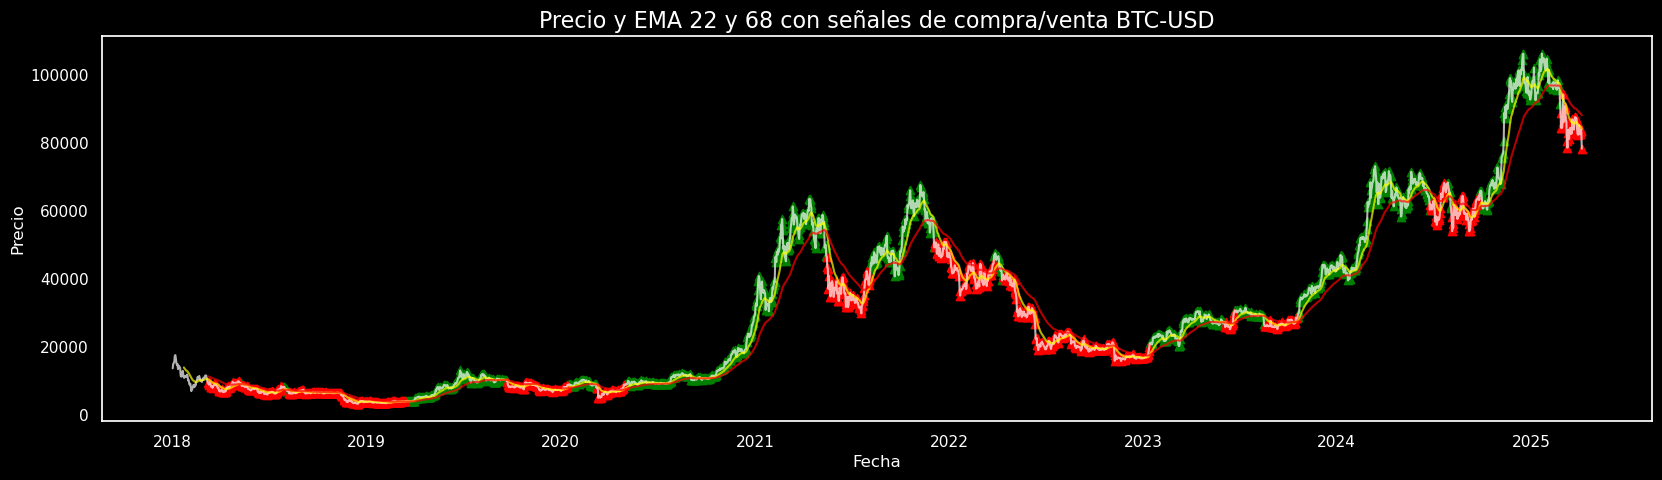

In [5]:
# Gráfico de compra y venta 
plt.plot(df.index, 
         df['Close'], 
         label='Precio de cierre', 
         color='white', 
         alpha=0.7)

plt.plot(df.index, 
         df['EMA_22'], 
         label='EMA_22', 
         color='yellow', 
         alpha=0.7)

plt.plot(df.index, 
         df['EMA_68'], 
         label='EMA_68', 
         color='red', 
         alpha=0.7)

plt.scatter(df.index[df['Signal'] == 1],
            df['Close'][df['Signal'] == 1],
            marker='^',
            color='green',
            label='Compra',
            alpha=1)

plt.scatter(df.index[df['Signal'] == -1],
            df['Close'][df['Signal'] == -1],
            marker='^',
            color='red',
            label='Venta',
            alpha=1)

plt.title(f'Precio y EMA 22 y 68 con señales de compra/venta {activo}', fontsize=16)
plt.xlabel(f'Fecha')
plt.ylabel(f'Precio')
plt.show()

In [6]:
# Simular ejecución de ordenes
df['Position'] = df['Signal'].shift()

In [7]:
# Definir comisiones y Slippage
commission= 0.001 # 0.1% por operación
slippage= 0.0005 # 0.05% de slippage en cada operación

# calcular los retornos de la estrategia con la comisión y slppage
df['Returns'] = df['Close'].pct_change() # Retornos diarios del activo
df['Strategy_Returns'] = df['Position'] * df['Returns']

#Aplicar comisiones y Slippage, ajustar según tu broker
df['Strategy_Returns'] -= (abs(df['Position'].diff())) * (commission * slippage)

# Eliminar NaNs
df.dropna(inplace=True)

In [8]:
#Calcular rendimiento total y anualiado
total_return = (df['Strategy_Returns'] + 1).prod() - 1
annualized_return = (1 + total_return) ** (252 / len(df)) - 1 #Ajustado por 252 dias de trading

print(f'Rendimiento Total: {total_return:.2%}')
print(f'Rendimiento Anualizado: {annualized_return:.2%}')

Rendimiento Total: 1303.06%
Rendimiento Anualizado: 29.35%


In [9]:
# Ratio de Sharpe
risk_free_rate = 0.04 
excess_return = df['Strategy_Returns'].mean() - (risk_free_rate / 252)
sharpe_ratio = excess_return / df['Strategy_Returns'].std()
print(f'Ratio de sharpe: {sharpe_ratio:2%}')

Ratio de sharpe: 4.225555%


In [10]:
#Drawdown Máximo
df['Cumulative_Returns'] = (df['Strategy_Returns'] + 1).cumprod()
df['Peak'] = df['Cumulative_Returns'].cummax()
df['Drawdown'] = (df['Cumulative_Returns'] - df['Peak']) / df['Peak'] 
max_drawdown = df['Drawdown'].min()
print(f'Máximo Drawdown: {max_drawdown:.2%}')

Máximo Drawdown: -62.16%


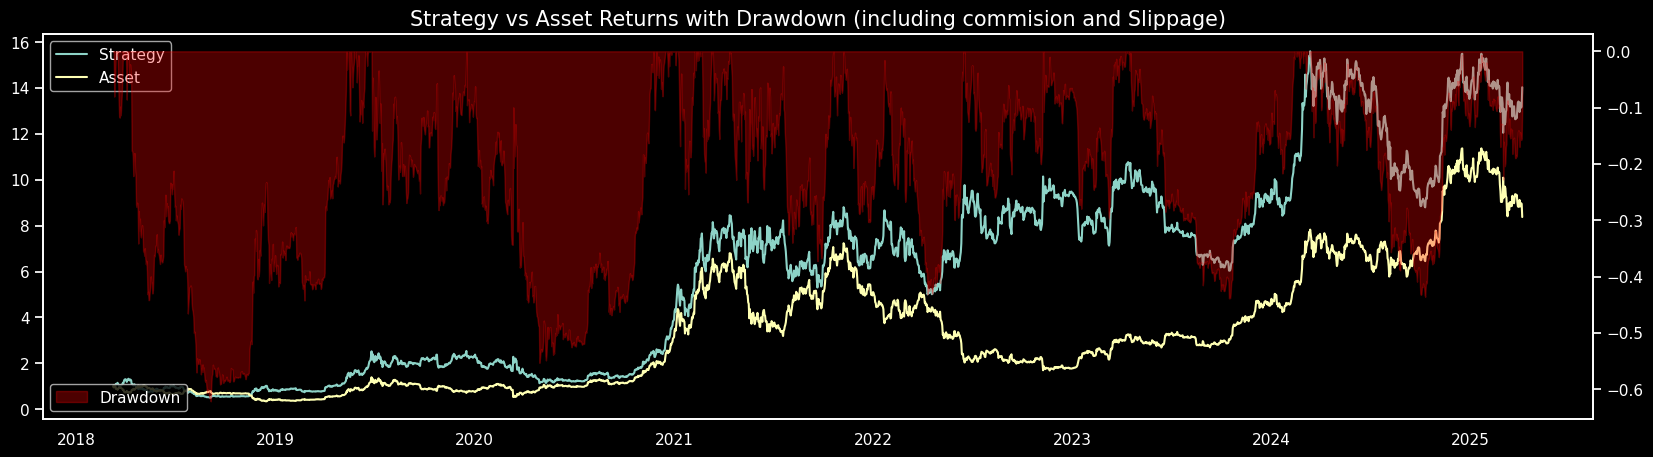

In [11]:
# Graficar el rendimiento de la estrategia frente al activo
fig, ax1 = plt.subplots()

# Graficar los rendimiento acumulado de la estrategia
ax1.plot(df.index,
         df['Cumulative_Returns'],
         label='Strategy')

# Graficar los rendimientos acumulados del activo usando close
ax1.plot(df.index,
        (df['Close'] / df['Close'].iloc[0]), 
        label='Asset')

# Gráficar el drawdown coloreando
ax2 = ax1.twinx()
ax2.fill_between(df.index,
                 df['Drawdown'],
                 0,
                 color='red',
                 alpha=0.3,
                 label='Drawdown')

# Configurar leyendas y títulos
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.title('Strategy vs Asset Returns with Drawdown (including commision and Slippage)', fontsize=15)

plt.show()